## Analyse Future Populations

Despite outliers being removed from the validation and holdout set, initial analysis with fitted models indicated strange populations of fruit.

The purpose of this notebook is to document these populations, flag them and remove them from future comparisons.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from utils import peval

In [2]:
dfs = {
    "model_1": pd.read_pickle("data/predictions/model_1.pkl"),
    "model_2": pd.read_pickle("data/predictions/model_2.pkl"),
    "model_3": pd.read_pickle("data/predictions/model_3.pkl"),
}
dfs["combined"] = pd.concat(dfs.values(), keys=dfs.keys(), names=["model", "original_index"])
dfs["combined"].reset_index(level="model", inplace=True)
dfs["combined"].reset_index(inplace=True)

dfs["combined"]

,original_index,model,partition,train_partition,subsequent_flag_1,sample_order_1,partition_ext,origin,population,date,...,region,cultivar,physio_stage,temp,reference_no,dry_matter,instrument,spectra_no,y_true,y_pred
0,36408,model_1,train,calibration,0,0,,nich,105600,2017-10-09,...,NT,1201,green,undef,3391,18.060310,15016,37690,18.060310,18.625060
1,45878,model_1,train,calibration,0,1,,nich,107201,2017-10-27,...,NT,caly,green,undef,4076,15.135730,15038,46920,15.135730,15.864243
2,44252,model_1,train,calibration,0,3,,nich,106900,2017-10-23,...,NT,kp,green,undef,3943,22.901620,15029,45604,22.901620,20.577597
3,24234,model_1,train,calibration,0,4,,nich,103109,2016-10-14,...,NT,r2e2,ripen,mid,1988,13.186000,15015,25544,13.186000,13.849288
4,22556,model_1,train,calibration,0,6,,nich,103105,2016-10-13,...,NT,caly,ripen,low,1824,18.594000,15023,23782,18.594000,17.694735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234472,71902,model_3,validation,calibration,0,85396,,nich,112500,2019-03-04,...,QLD,caly,ripen,undef,7550,13.774184,18029,77108,13.774184,14.227664
234473,6947,model_3,train,calibration,0,85397,,nich,100600,2015-10-23,...,NT,kp,green,mid,214,12.187465,15029,6439,12.187465,14.446321
234474,48401,model_3,train,calibration,0,85398,,nich,107400,2017-11-17,...,QLD,hg,green,undef,4325,13.775450,15038,49711,13.775450,15.271643
234475,59457,model_3,validation,tunning,0,85399,,nich,109900,2018-08-07,...,NT,caly,ripen,undef,5425,15.969130,15027,60783,15.969130,16.104063


In [3]:
# df.query("subsequent_flag_1 != 0 and partition_ext == 'anderson_external_val'").groupby(["subsequent_flag_1"]).size()

In [4]:
train_instruments = (
    dfs["model_1"].query("partition == 'train'")
    # predictions.query("season in (2015, 2016, 2017, 2018)")
    .groupby(["instrument"])
    .size()
    .reset_index()
)["instrument"].to_list()

## Metrics for test sets

### Table

In [5]:
remove_subsequently_flagged = False

all_metrics = []
test_sets = {
    # "training": "partition == 'train'",
    # "training_calibration": "partition == 'train' and train_partition == 'calibration'",
    # "training_tuning": "partition == 'train' and train_partition == 'tunning'",
    
    # "validation": "subsequent_flag_1 == 0 and partition == 'validation'",
    # "season 2018": "subsequent_flag_1 == 0 and season == 2018",
    # "season 2019": "subsequent_flag_1 == 0 and season == 2019",
    # "anderson*": "partition_ext == 'anderson_external_val'",
    # "anderson": "subsequent_flag_1 == 0 and partition_ext == 'anderson_external_val'",
    # "walsh*": "partition_ext == 'walsh_external_val'",
    
    # "holdout": "subsequent_flag_1 == 0 and partition == 'holdout'",
    "validation_same_instruments": f"subsequent_flag_1 == 0 and partition == 'validation' and instrument in ({train_instruments})"
    
}

for model, df in dfs.items():
    if model == "combined":
        continue
    if remove_subsequently_flagged:
        df = df.query("subsequent_flag_1 == 0")
    for test_set, query in test_sets.items():
        test_partition = df.query(query) 
        metrics = peval.calculate_metrics(y_true=test_partition["y_true"], y_pred=test_partition["y_pred"], plot=False)
        metrics["model"] = model
        metrics["populations"] = len(test_partition["population"].unique())
        metrics["instruments"] = len(test_partition["instrument"].unique())
        metrics["test_set"] = test_set
        all_metrics.append(metrics)

metrics = pd.DataFrame(all_metrics)
set_metrics = metrics[["model", "test_set", "populations", "instruments", "n", "rmse", "sep", "bias"]].set_index(["model", "test_set", "populations", "instruments", "n"]).unstack(level=0)
set_metrics.columns = ["_".join(col).strip() for col in set_metrics.columns.values]
set_metrics["rmse_mean"] = (set_metrics["rmse_model_1"] + set_metrics["rmse_model_2"] + set_metrics["rmse_model_3"])/3
set_metrics["sep_mean"] = (set_metrics["sep_model_1"] + set_metrics["sep_model_2"] + set_metrics["sep_model_3"])/3
set_metrics["bias_mean"] = (set_metrics["bias_model_1"] + set_metrics["bias_model_2"] + set_metrics["bias_model_3"])/3
set_metrics.reset_index(inplace=True)
# set_metrics.sort_values(by="rmse_mean", ascending=False, inplace=True)
set_metrics


,test_set,populations,instruments,n,rmse_model_1,rmse_model_2,rmse_model_3,sep_model_1,sep_model_2,sep_model_3,bias_model_1,bias_model_2,bias_model_3,rmse_mean,sep_mean,bias_mean
0,validation_same_instruments,37,15,7450,1.126005,0.910669,0.985789,1.124596,0.90856,0.984433,0.057801,0.062828,-0.052939,1.007488,1.005863,0.022563


### Plot

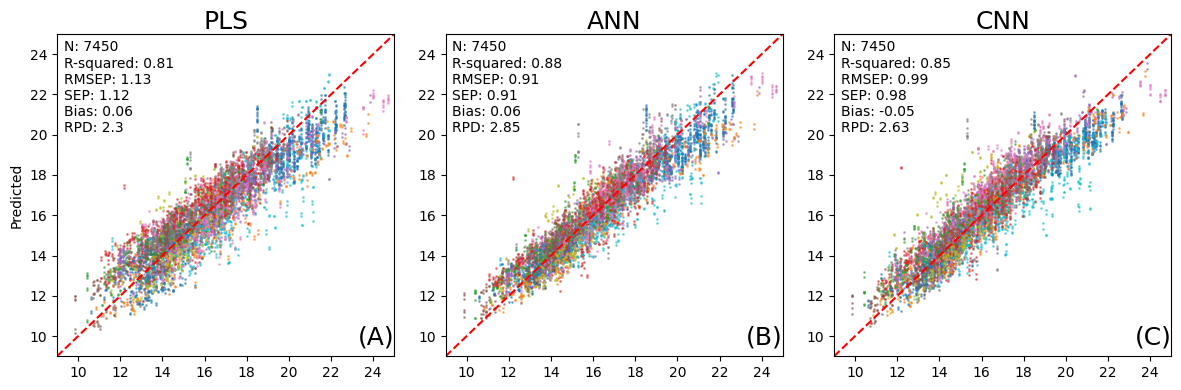

In [6]:
remove_subsequently_flagged = False

# create a figure with subplots - 4 rows (one for each query) and 3 columns (one for each model)
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('default')
fig, axes = plt.subplots(len(test_sets), 3, figsize=(12, 4*len(test_sets)))

# global min and max for axis scaling
global_min, global_max = 9, 25
test_sets


for i, (key, query) in enumerate(test_sets.items()):
    models = {
        "PLS": dfs["model_1"].query(query),
        "ANN": dfs["model_2"].query(query),
        "CNN": dfs["model_3"].query(query)
    }
    if remove_subsequently_flagged:
        models = {
            "PLS": dfs["model_1"].query(query).query("subsequent_flag_1 == 0"),
            "ANN": dfs["model_2"].query(query).query("subsequent_flag_1 == 0"),
            "CNN": dfs["model_3"].query(query).query("subsequent_flag_1 == 0")
        }
    
    # calculate metrics for each model
    metrics = {}
    for model_name, data in models.items():
        metrics[model_name] = peval.calculate_metrics(y_true=data["y_true"], y_pred=data["y_pred"], plot=False)
    stats = {}
    for model_name, metric in metrics.items():
        stats[model_name] = f"N: {metric['n']}\nR-squared: {round(metric['r2'], 2)}\nRMSEP: {round(metric['rmse'], 2)}\nSEP: {round(metric['sep'], 2)}\nBias: {round(metric['bias'], 2)}\nRPD: {round(metric['rpd'], 2)}"
    
    # plotting
    for j, (model_name, data) in enumerate(models.items()):
        ax = axes[i, j] if len(test_sets) > 1 else axes[j]  # Handle indexing for axes
        
        # generate color mapping for populations
        unique_populations = data["population"].unique()
        for population in unique_populations:
            data_p = data[data["population"] == population]
            ax.scatter(data_p["y_true"], data_p["y_pred"], s=1, alpha=0.5)
        ax.plot([global_min, global_max], [global_min, global_max], linestyle='--', color='red')
        
        if j in [0]: 
            ax.set_ylabel("Predicted")
            
        if i in [0]: 
            ax.set_title(model_name, fontsize=18, pad=-2)
            
        if i == len(models.items()) + 1: 
            # Only set xlabel for the bottom subplot
            ax.set_xlabel("Reference")
        
        ax.text(0.02, 0.98, stats[model_name], transform=ax.transAxes, fontsize=10, ha='left', va='top')
        title_label = chr(65 + i*3 + j)
        ax.text(1.0, 0.02, f"({title_label})", transform=ax.transAxes, fontsize=18, ha='right', va='bottom') 
        
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        


plt.tight_layout()
plt.show()
